In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw9.ipynb")

In [3]:
#import packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
data = pd.read_csv("utility/data/housing.csv") #reading csv file and storing it in a dataframe
data.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

This data was downloaded from Kaggle. It was collected from the 1990 California census. It has 20640 examples with 10 features. All of the features, except ocean_proximity, takes a numerical value, while ocean_proximity is categorical. All of the numerical features are continuous, and the categorical feature is ordinal. All of the fetures are related to the block, so any median values are the median of the houses within a block of eachother, and any total values are the total of all the houses within a block. I want to explore how the features affect the median_house_value, since the price of a house is affected by all of the features provided.

The domain is a business problem. When people are looking to place their house on the market, they need to know what price to list the house based on its location and design. If a house is priced too high, people won't be interested in buying it, but if it's priced too low, the current owner won't make as much money off the sale. This is a regression problem because the pricing of the house is a numerical value that is predicted on a continuous scale. For a regression model using one variable, median income would be the best predictor since it's the most correlated with median house value. This report showed that I have to get rid of null values since there are over 200 of them. I also should encode the catoegorical feature since it's the only non-numerical value. 

In [5]:
# BEGIN SOLUTION
import sys
#!{sys.executable} -m pip install pandas-profiling
import pandas as pd
from pandas_profiling import ProfileReport
# END SOLUTION

In [6]:
profile = ProfileReport(data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:

data_new = data
data_new['ocean_proximity'] = data_new['ocean_proximity'].replace({item: i for i, item in enumerate(data_new['ocean_proximity'].unique())})
    #NEAR BAY = 0; <1H OCEAN = 1; INLAND = 2; NEAR OCEAN = 3; ISLAND = 4
    


Total rooms, total bedrooms, population, and households are correlated with each other. Median house value and median income are also correlated. Longitude and latitude are negatively correlated with each other. Positive correlations are shown in dark blue and negative correlations are shown in red on the chart. The median house value with the greatest frequency is 500001, so I am assuming that any house with a value of 500001 or greater was all said to be worth 500001 since it's unlikely that the most houses cost this exact amount. I also think any house that was older than 52 years old was said to be 52 years old for the same reason. Total rooms, total bedrooms, population, and households have significant outliers. Median income also has outliers, but this is more expected since there are people of many different economic classes. Total bedrooms has a lot of missing data.

80% of the data should be used for training so that the model has enough samples to learn from, and this helps to ensure the model is general enough for all the data and that it's not too specific for just a couple of samples. 20% should be used for testing so that majority of the data is used for training, but there are still enough samples to test a wide range of examples. If the data is relatively small, then I have to make sure that there is enough variety in the training data and that all of the features are equally represented. I also have to make sure the test data set is large enough to test all possible cases. If the dataset is large, the test set can be smaller since a smaller percentage of data will be sufficient enough to test all possible cases. Cross validation helps to evaluate the model while still making changes to the model parameters. Since the model has already seen this data, the validation set shouldn't be used as the final evaluation of the model (the test set should be used instead). Data snooping is when the person or model looks at the data before making predictions. This can lead to overfitting or to more signifigant results than there should be. This can be avoided by having train, validation, and test data sets that are not looked at until it is appropriate to do so. This can also be avoided by conducting multiple evaluation/accuracy tests.

In [8]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

X = data_new.drop(columns=['median_house_value']) #Extracting target variable
y = data_new['median_house_value'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #Splitting into test and train

mean_bedrooms = X_train["total_bedrooms"].mean()
data_new["total_bedrooms"].fillna(mean_bedrooms, inplace = True) #replacing missing values in total_bedrooms with the mean of the feature from the training dataset
X_train["total_bedrooms"].fillna(mean_bedrooms, inplace = True)
X_test["total_bedrooms"].fillna(mean_bedrooms, inplace = True)

kf = KFold(n_splits=5, shuffle=True) #Preparing to split training data into a validation set


/Users/emzeiberg/opt/miniconda3/envs/cse217a/lib/python3.7/site-packages/pandas/core/series.py:4439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


R^2 is the most intuitive since 1 corresponds to an accurate model, and 0 corresponds to a non-accurate model. The other methods are less intuitive because of the range of value they use and also they may have factors that don't make as much sense (such as using different units).

In [9]:
# BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2_linear = np.zeros(5)
rmse_linear = np.zeros(5)
X_train_arr = np.array(X_train)
y_train_arr = np.array(y_train)
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train)): #Creating a new model for each validation set
    model_linear = LinearRegression()
    model_linear.fit(X_train_arr[train_idx], y_train_arr[train_idx]) #fitting model
    y_pred_linear = model_linear.predict(X_train_arr[test_idx]) #Predictions using validation set
    r2 = r2_score(y_train_arr[test_idx], y_pred_linear)
    rmse = np.sqrt(mean_squared_error(y_train_arr[test_idx], y_pred_linear))
    r2_linear[fold-1] = r2
    rmse_linear[fold-1] = rmse
print('R^2: {}' .format(r2_linear.mean()))
print('RMSE: {}' .format(rmse_linear.mean()))
# END SOLUTION

R^2: 0.6308571626375397
RMSE: 69629.50988743744


I already enocoded the catagorical data in problem 1.3. I did this so that the linear regression model could use this feature, and it's easier to process numerical data than catagorical data. I also replaced the missing values in total_bedrooms with the mean of that feature. This is helpful so that I don't have to delete the entire sample because of one missing value. In the next cell, I create new data sets for scaled x train and x test. This is an important step since some models only work well if each feature within the data is a similar size, and standardization helps to do this. In section 2.3, I also try feature selection using a random forest classifier, and I try to generate my own feature. Feature selection is useful since only features with a high importance score are used, so there isn't excess/nonrelavent features affecting predictions. Feature generation can help to provide additional useful features to the model.


In [10]:

#Standardize data
scaler = preprocessing.StandardScaler().fit(X_train) # computing the mean and standard deviation on a training set 
X_train_scaled = scaler.transform(X_train) # apply the transforamtion to the trainnig set
X_test_scaled = scaler.transform(X_test) # apply the transforamtion to the test set



In [11]:


#Extracting if the homes are in a crowded area. 1 if population is greater than 2000, 0 otherwise.
for dataset in [X_train, X_test]:
    dataset["dense_area"] = dataset["population"].apply(lambda x: 1 if x > 2000 else 0)

print(X_train)


       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
634      -122.16     37.71                37.0       1507.0           242.0   
2011     -119.83     36.73                21.0       1702.0           358.0   
10484    -117.69     33.58                 8.0       2887.0           351.0   
9425     -122.71     37.90                23.0       1250.0           257.0   
15654    -122.40     37.79                52.0       1185.0           660.0   
...          ...       ...                 ...          ...             ...   
4647     -118.31     34.06                52.0       2124.0           756.0   
12020    -117.46     33.95                34.0       1565.0           296.0   
20212    -119.22     34.28                24.0       2212.0           332.0   
3262     -122.90     39.17                45.0       1314.0           277.0   
16927    -122.33     37.58                43.0       1772.0           422.0   

       population  households  median_income  ocean

/Users/emzeiberg/opt/miniconda3/envs/cse217a/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
#Performing feature selection
def get_RF_mask(X_in,y_in, model_in):
    
    importance = None
    mask = None
    model_in.fit(X_in, y_in)
    importance = model_in.feature_importances_ #Calculates feature importance
    print(importance)
    median_importance = np.median(importance)
    mask = importance > median_importance
    
    return mask
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, random_state=10) #Using random forest model

rf_mask = get_RF_mask(X_train, y_train, model) 

X_train_selected = np.array(X_train)[:,rf_mask] #applying mask
print(f'     All Features: {X_train.shape}')
print(f'Selected Features: {X_train_selected.shape}')


[0.11852027 0.12070072 0.10549799 0.12621176 0.11853071 0.12673747
 0.11878282 0.14623701 0.01137191 0.00740933]
     All Features: (16512, 10)
Selected Features: (16512, 5)


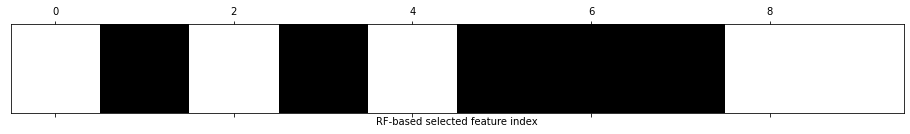

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  media

In [13]:
#Plotting which features were selected
plt.matshow(rf_mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("RF-based selected feature index")
plt.yticks(())
plt.show()
print(data)

In [14]:
#Creating new test and train datasets using standardized data
X_train_engineered = X_train_scaled[:,:8]
X_test_engineered = X_test_scaled[:,:8]


KNN predicts a data point based on the labels of its nearest neighbors. Because of this, I have to first find what is the best number of neighbors to use. I can use cross-validation to do this.

In [15]:
def knn_kfolds(X_knn, y_knn, n_folds, n_neighbors, random_state=10):
    rmse_fold = []
    r2_fold = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_knn)):
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        X_tr, X_val, y_tr, y_val = X_knn[train_idx], X_knn[test_idx], y_knn[train_idx], y_knn[test_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        r2_fold.append(r2)
        avg_r2 = np.mean(r2_fold)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_fold.append(rmse)
        avg_rmse = np.mean(rmse_fold)
    return avg_r2, avg_rmse

Text(0.5, 1.0, 'R^2 values for different number of NN')

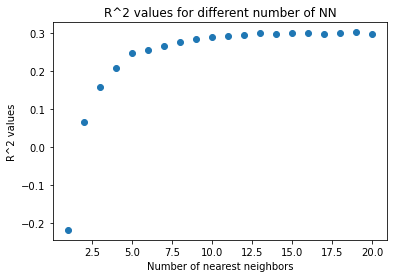

In [16]:
# BEGIN SOLUTION
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
R2_vals = []
for k in range(1,21):
    r2, rmse = knn_kfolds(np.array(X_train), np.array(y_train), 5, k)
    R2_vals.append(r2)
plt.scatter(range(1,21), R2_vals) #Creating plot to determine the best number of neighbors to us
plt.xlabel('Number of nearest neighbors')
plt.ylabel('R^2 values')
plt.title('R^2 values for different number of NN')


# END SOLUTION

In [17]:
#Predictions for test data
knn_model = KNeighborsRegressor(n_neighbors=16)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
cross_val_r2 = r2_score(y_test, y_pred_knn)
cross_val_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print('RMSE: %f' %(cross_val_rmse))
print('R^2: %f' %(cross_val_r2))

RMSE: 96415.994266
R^2: 0.336609


Text(0.5, 1.0, 'R^2 values for different number of NN')

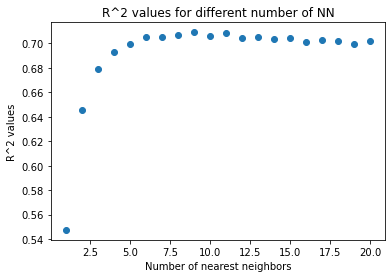

In [18]:
#Same process as before, but now training/testing with engineered data

R2_vals_engr = []
r2 = None
rmse = None
for k in range(1,21):
    r2, rmse = knn_kfolds(np.array(X_train_engineered), np.array(y_train), 5, k)
    R2_vals_engr.append(r2)
plt.scatter(range(1,21), R2_vals_engr)
plt.xlabel('Number of nearest neighbors')
plt.ylabel('R^2 values')
plt.title('R^2 values for different number of NN')


In [19]:
knn_model_engr = KNeighborsRegressor(n_neighbors=10)
knn_model_engr.fit(X_train_engineered, y_train)
y_pred_knn_engr = knn_model_engr.predict(X_test_engineered)
cross_val_r2_engr = r2_score(y_test, y_pred_knn_engr)
cross_val_rmse_engr = np.sqrt(mean_squared_error(y_test, y_pred_knn_engr))
print('RMSE Engineered: %f' %(cross_val_rmse_engr))
print('R^2 Engineered: %f' %(cross_val_r2_engr))

RMSE Engineered: 62064.366054
R^2 Engineered: 0.725112


An advantage of using decision tree over linear regression and KNN is that I don't have to determine how many neighbors to use, but I do have to determine the best depth of the tree to use. If the data has distinct groups than the depth of the tree is not that large, but if the data is mixed together, than the depth must be large and this can increase the run time. Another advantage of a decision tree is that you don't need to use the training data everytime a new point is added. For KNN, you have to keep the training data so that you can find the nearest neighbors, but for decision trees, once the model is fitted, you don't need to use the training data everytime. 

In [20]:
from sklearn.tree import DecisionTreeRegressor
#using cross validation to determine depth of tree
def tree_kfolds(X_tree_fold, y_tree_fold, n_folds_tree, max_depth_tree, random_state=10):
    rmse_fold_tree = []
    r2_fold_tree = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_tree_fold)):
        model_tree_fold = DecisionTreeRegressor(max_depth=max_depth_tree)
        X_tr_tree_fold, X_val_tree_fold, y_tr_tree_fold, y_val_tree_fold = X_tree_fold[train_idx], X_tree_fold[test_idx], y_tree_fold[train_idx], y_tree_fold[test_idx]
        model_tree_fold.fit(X_tr_tree_fold, y_tr_tree_fold)
        y_pred_tree_fold = model_tree_fold.predict(X_val_tree_fold)
        r2 = r2_score(y_val_tree_fold, y_pred_tree_fold)
        r2_fold_tree.append(r2)
        avg_r2 = np.mean(r2_fold_tree)
        rmse =np.sqrt(mean_squared_error(y_val_tree_fold, y_pred_tree_fold))
        rmse_fold_tree.append(rmse)
        avg_rmse = np.mean(rmse_fold_tree)
    return avg_r2, avg_rmse

9


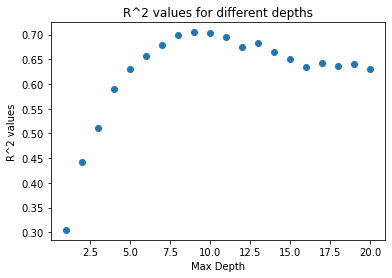

In [21]:
from sklearn.tree import DecisionTreeRegressor
r2_vals_tree = []
for k in range(1,21):
    r2_tree, rmse_tree = tree_kfolds(np.array(X_train), np.array(y_train), 5, k, random_state=10)
    r2_vals_tree.append(r2_tree)
plt.scatter(range(1,21), r2_vals_tree) #Plot to determine best depth of the tree to use
plt.xlabel('Max Depth')
plt.ylabel('R^2 values')
plt.title('R^2 values for different depths')
max_value_tree = max(r2_vals_tree)
max_index_tree = r2_vals_tree.index(max_value_tree)
print(max_index_tree+1)

In [22]:
#Predictions for test data
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(max_depth=9, random_state=10)
tree_model.fit(X_train, y_train)

# Predict
ypred_tree = tree_model.predict(X_test)

rmse_tree = np.sqrt(mean_squared_error(y_test, ypred_tree))
r2_tree = r2_score(y_test, ypred_tree)

print('RMSE: %f' %(rmse_tree))
print('R^2: %f' %(r2_tree))

RMSE: 64083.834608
R^2: 0.706932


11
RMSE: 65164.962882
R^2: 0.696960


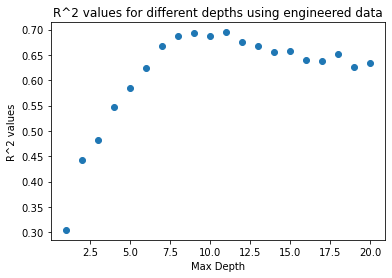

In [23]:
#Same process as before, but now training/testing with engineered data

r2_vals_tree_engr = []
for k in range(1,21):
    r2_tree_engr, rmse_tree_engr = tree_kfolds(np.array(X_train_engineered), np.array(y_train), 5, k, random_state=10)
    r2_vals_tree_engr.append(r2_tree_engr)
plt.scatter(range(1,21), r2_vals_tree_engr)
plt.xlabel('Max Depth')
plt.ylabel('R^2 values')
plt.title('R^2 values for different depths using engineered data')
max_value_tree_engr = max(r2_vals_tree_engr)
max_index_tree_engr = r2_vals_tree_engr.index(max_value_tree_engr)
print(max_index_tree_engr+1)


tree_model_engr = DecisionTreeRegressor(max_depth=9, random_state=10)
tree_model_engr.fit(X_train_engineered, y_train)

# Predict
ypred_tree_engr = tree_model_engr.predict(X_test_engineered)

rmse_tree_engr = np.sqrt(mean_squared_error(y_test, ypred_tree_engr))
r2_tree_engr = r2_score(y_test, ypred_tree_engr)

print('RMSE: %f' %(rmse_tree_engr))
print('R^2: %f' %(r2_tree_engr))


A random forest is made up of multiple decision trees, so you can take the averages of all the trees to determine the prediction for a sample. If you only use one tree, you have a higher chance of getting the wrong label, but if you use the average of multiple trees, this increases the chance of a correct prediction.

In [24]:
from sklearn.ensemble import RandomForestRegressor
#Using cross validation to determine best number of trees to use
def forest_kfolds(X_forest_fold, y_forest_fold, n_folds_forest, max_estimators_forest, random_state=10):
    rmse_fold_forest = []
    r2_fold_forest = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_forest_fold)):
        model_forest_fold = RandomForestRegressor(n_estimators=max_estimators_forest, random_state=10, max_depth=9)
        X_tr_forest_fold, X_val_forest_fold, y_tr_forest_fold, y_val_forest_fold = X_forest_fold[train_idx], X_forest_fold[test_idx], y_forest_fold[train_idx], y_forest_fold[test_idx]
        model_forest_fold.fit(X_tr_forest_fold, y_tr_forest_fold)
        y_pred_forest_fold = model_forest_fold.predict(X_val_forest_fold)
        r2 = r2_score(y_val_forest_fold, y_pred_forest_fold)
        r2_fold_forest.append(r2)
        avg_r2 = np.mean(r2_fold_forest)
        rmse = np.sqrt(mean_squared_error(y_val_forest_fold, y_pred_forest_fold))
        rmse_fold_forest.append(rmse)
        avg_rmse = np.mean(rmse_fold_forest)
    return avg_r2, avg_rmse

19


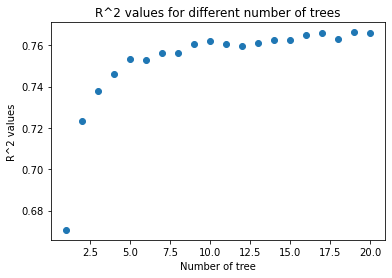

In [25]:
r2_vals_forest = []
for k in range(1, 21):
    r2_forest, rmse_forest = forest_kfolds(np.array(X_train), np.array(y_train), 5, k, random_state=10)
    r2_vals_forest.append(r2_forest)
plt.scatter(range(1,21), r2_vals_forest) #Plot showing best number of trees to use
plt.xlabel('Number of tree')
plt.ylabel('R^2 values')
plt.title('R^2 values for different number of trees')
max_value_forest = max(r2_vals_forest)
max_index_forest = r2_vals_forest.index(max_value_forest)
print(max_index_forest+1)

In [26]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators=18, random_state=10, max_depth=9)

forest_model.fit(X_train, y_train)
ypred_forest = forest_model.predict(X_test)

rmse_forest = np.sqrt(mean_squared_error(y_test, ypred_forest))
r2_forest = r2_score(y_test, ypred_forest)

print('RMSE: %f' %(rmse_forest))
print('R^2: %f' %(r2_forest))


RMSE: 57070.315571
R^2: 0.767570


18


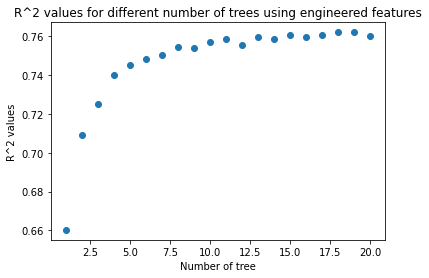

In [27]:
#Same process as before, but now training/testing with engineered data
r2_vals_forest_engr = []
for k in range(1, 21):
    r2_forest_engr, rmse_forest_engr = forest_kfolds(np.array(X_train_engineered), np.array(y_train), 5, k, random_state=10)
    r2_vals_forest_engr.append(r2_forest_engr)
plt.scatter(range(1,21), r2_vals_forest_engr)
plt.xlabel('Number of tree')
plt.ylabel('R^2 values')
plt.title('R^2 values for different number of trees using engineered features')
max_value_forest_engr = max(r2_vals_forest_engr)
max_index_forest_engr = r2_vals_forest_engr.index(max_value_forest_engr)
print(max_index_forest_engr+1)


In [28]:
forest_model_engr = RandomForestRegressor(n_estimators=19, random_state=10, max_depth=9)

forest_model.fit(X_train_engineered, y_train)
ypred_forest_engr = forest_model.predict(X_test_engineered)

rmse_forest_engr = np.sqrt(mean_squared_error(y_test, ypred_forest_engr))
r2_forest_engr = r2_score(y_test, ypred_forest_engr)

print('RMSE: %f' %(rmse_forest_engr))
print('R^2: %f' %(r2_forest_engr))

RMSE: 57855.910852
R^2: 0.761127


This model is trained using only one feature, but earlier, I trained the model using all features. This is statistical feature selection since median income is the most correlated with median house value, so this feature can lead to the best predictions.

In [29]:
med_income_train = X_train_arr[:,7].reshape(-1, 1)
r2_linear_all = np.zeros(5)
rmse_linear_all = np.zeros(5)
for fold, (train_idx, test_idx) in enumerate(kf.split(med_income_train)):
    model_linear_all = LinearRegression()
    model_linear_all.fit(med_income_train[train_idx], y_train_arr[train_idx])
    y_pred_linear_all = model_linear_all.predict(med_income_train[test_idx])
    r2 = r2_score(y_train_arr[test_idx], y_pred_linear_all)
    rmse = np.sqrt(mean_squared_error(y_train_arr[test_idx], y_pred_linear_all))
    r2_linear_all[fold-1] = r2
    rmse_linear_all[fold-1] = rmse
print('R^2: {}' .format(r2_linear_all.mean()))
print('RMSE: {}' .format(rmse_linear_all.mean()))


R^2: 0.4714917391326381
RMSE: 83325.09757662984


In [30]:
from sklearn.linear_model import LinearRegression
med_income_test = np.array(X_test)[:,7].reshape(-1, 1)
model_lin_1_var = LinearRegression()
model_lin_1_var.fit(med_income_train, y_train)
y_pred_lin_1_var = model_lin_1_var.predict(med_income_test)
rmse_lin_1_var = np.sqrt(mean_squared_error(y_test, y_pred_lin_1_var))
r2_lin_1_var = r2_score(y_test, y_pred_lin_1_var)
print('RMSE: %f' %(rmse_lin_1_var))
print('R^2: %f' %(r2_lin_1_var))


RMSE: 85402.679904
R^2: 0.479507


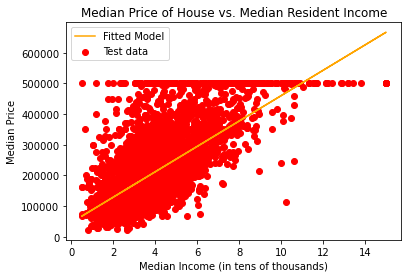

In [31]:
#Plot with testing data
plt.scatter(med_income_test, y_test, color="red", label='Test data')
plt.plot(med_income_test, y_pred_lin_1_var, color="orange", label='Fitted Model')
plt.title('Median Price of House vs. Median Resident Income')
plt.xlabel("Median Income (in tens of thousands)")
plt.ylabel("Median Price")
plt.legend()
plt.show()


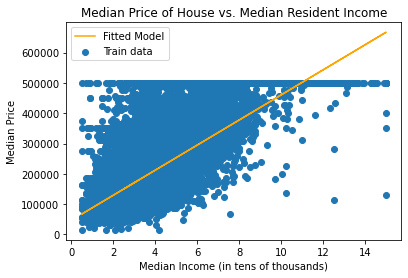

In [32]:
#Plot with training data
plt.scatter(med_income_train, y_train, label='Train data')
plt.plot(med_income_test, y_pred_lin_1_var, color="orange", label='Fitted Model')
plt.title('Median Price of House vs. Median Resident Income')
plt.xlabel("Median Income (in tens of thousands)")
plt.ylabel("Median Price")
plt.legend()
plt.show()


In [33]:
#same process as before, but using engineered features
med_income_train_engr = X_train_engineered[:,7].reshape(-1, 1)
med_income_test_engr = np.array(X_test_engineered)[:,7].reshape(-1, 1)
model_lin_1_var_engr = LinearRegression()
model_lin_1_var_engr.fit(med_income_train_engr, y_train)
y_pred_lin_1_var_engr = model_lin_1_var_engr.predict(med_income_test_engr)
rmse_lin_1_var_engr = np.sqrt(mean_squared_error(y_test, y_pred_lin_1_var_engr))
r2_lin_1_var_engr = r2_score(y_test, y_pred_lin_1_var_engr)
print('RMSE: %f' %(rmse_lin_1_var_engr))
print('R^2: %f' %(r2_lin_1_var_engr))

RMSE: 85402.679904
R^2: 0.479507


## 4. Model Comparision

The lowest accuracy score is the KNN model with the original data. I think this is because KNN isn't accurate if features aren't of a similar magnitude.

Text(0.5, 1.0, 'r^2 Score for Different Models Using Original Features')

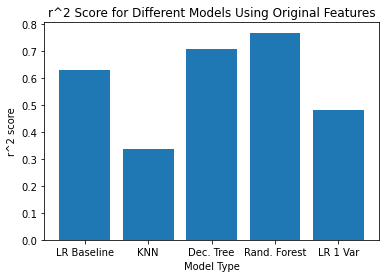

In [34]:
# BEGIN SOLUTION
r2_baseline = r2_linear.mean()
plt.bar(['LR Baseline', 'KNN', 'Dec. Tree', 'Rand. Forest', 'LR 1 Var'], [r2_baseline, cross_val_r2, r2_tree, r2_forest, r2_lin_1_var])
plt.xlabel('Model Type')
plt.ylabel('r^2 score')
plt.title('r^2 Score for Different Models Using Original Features')

# END SOLUTION

I only scaled the features for this dataset. I tried also using feature selection, where I used only the features with the highest importance, but when I tested the models using the validation sets, I found the r^2 score went down, so even the features with a lower importance were necessary for making the most accurate model. I also tried generating a feature that classified if the data was taken in a densely populated area, because I thought crowded areas would indicate a city, and city homes are typically more expensive. However, again when I used the validation set on the KNN model, I found the model was worse using this feature. The only way I found that improved the KNN model specifically was scaling the features. My goal was to improve KNN model since this model was shown to be significantly worse than all the others using the original data.

Text(0.5, 1.0, 'r^2 Score for Different Models Using Engineered Features')

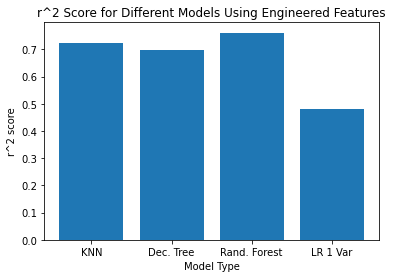

In [35]:
#R^2 score of models using engineered data
plt.bar(['KNN', 'Dec. Tree', 'Rand. Forest', 'LR 1 Var'], [cross_val_r2_engr, r2_tree_engr, r2_forest_engr, r2_lin_1_var_engr], label = "engineered features")
plt.xlabel('Model Type')
plt.ylabel('r^2 score')
plt.title('r^2 Score for Different Models Using Engineered Features')

Text(0.5, 1.0, 'r^2 Score Comparison of Original vs. Engineered Features')

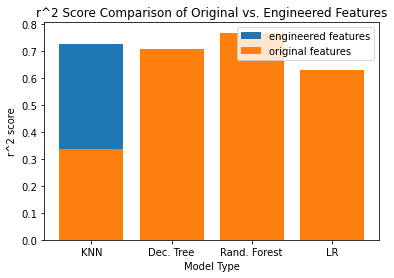

In [36]:

#Comparing orginal features vs. engineered
plt.bar(['KNN', 'Dec. Tree', 'Rand. Forest', 'LR'], [cross_val_r2_engr, r2_tree_engr, r2_forest_engr, r2_lin_1_var_engr], label = "engineered features")
plt.bar(['KNN', 'Dec. Tree', 'Rand. Forest', 'LR'], [cross_val_r2, r2_tree, r2_forest, r2_baseline], label = "original features")
plt.legend()
plt.xlabel('Model Type')
plt.ylabel('r^2 score')
plt.title('r^2 Score Comparison of Original vs. Engineered Features')


I didn't find feature selection or generation to be useful for this dataset. This is because all the features that were provided are necessary to determine the price of a house, and the feature I generated was less important than I originally anticipated it to be.

The only model that was significantly improved using the engineered features was the KNN model. This is because KNN makes predictions using the nearest neighbors, which is determined by distance. Originally, not all features were of the same magnitude. For example, median income was always under 15, but total rooms was in the hundreds. This causes median income to have a much bigger weight since the distance between two points in terms of median income will always be small. However, total rooms shouldn't have as small as a weight since a home with more rooms is typically more expensive. Scaling the data helps eliminate this problem so that all features are of similar magnitude and are accounted for equally. 

Models other than KNN were not as significantly impacted by scaling the data, as shown in the graph above. Linear regression wasn't affected since this model determines weights for each of the features, so the difference in magnitude between two features doesn't affect the predictions like it does with KNN. The decision tree and random forest models weren't affected by scaling the data since these models also don't use the distance between two points, so modifying the distance doesn't affect the predictions. The decision boundaries may be different for the scaled data, but the overall predictions aren't really changed.

The linear regression model was affected when I trained with one feature instead of all of the features. When training with just 1, the trends and information from the other features cannot be used for making predictions, so the predictions are less accurate. 

I compared all models using the R^2 score. Any model with a higher R^2 score was considered better than one with a lower score.


In [72]:
grader.check("hw9")

hw9 results: All test cases passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [73]:
grader.check_all()

hw9 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [74]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)